In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


data = pd.read_csv(r"company_03\merge.csv")  

data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data['sales'] = pd.to_numeric(data['sales'], errors='coerce')


In [3]:
data.columns

Index(['sales'], dtype='object')

In [4]:
data.fillna(method='ffill', inplace=True)  

train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

C:\Users\binay\AppData\Local\Temp\ipykernel_2092\107263219.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [5]:
train.shape

(44, 1)

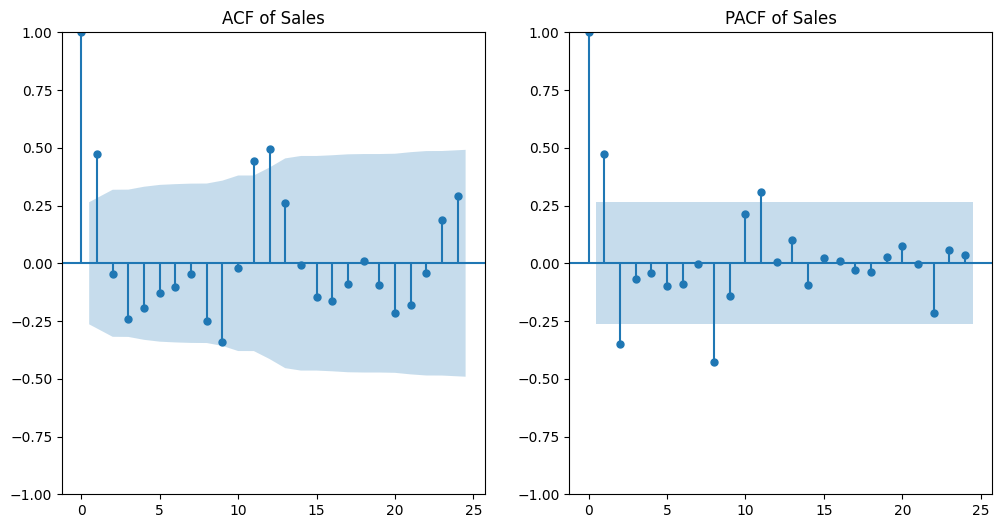

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['sales'], lags=24, ax=plt.gca())
plt.title("ACF of Sales")
plt.subplot(122)
plot_pacf(data['sales'], lags=24, ax=plt.gca())
plt.title("PACF of Sales")
plt.show()

In [7]:
selected_lags = 12

In [8]:
sarima_model = auto_arima(data['sales'], seasonal=True, m=12, 
                          d=1, D=1, max_p=5, max_q=5, max_order=10, trace=True, 
                          error_action='ignore', suppress_warnings=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1693.934, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1717.609, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1701.600, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1692.931, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1707.324, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1694.931, Time=0.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1694.931, Time=0.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1698.568, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1696.931, Time=0.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1692.521, Time=0.13 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1707.433, Time=0.03 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1694.454, Time=0.12 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1694.443, Time=0.16 sec
 ARIMA(1,1,1)(1,1,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   55
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -837.759
Date:                              Tue, 25 Feb 2025   AIC                           1685.517
Time:                                      15:50:44   BIC                           1694.205
Sample:                                  04-01-2077   HQIC                          1688.702
                                       - 10-01-2081                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4195      0.163     -2.568      0.010      -0.740      -0.099
ma.L2         -0.1716      0.258     -0.666      0.505      -0.676       0.333
ma.L3         -0.1553      0.228     -0.680      0.497      -0.603       0.292
ma.S.L12      -0.8364      0.233     -3.582      0.000      -1.294      -0.379
sigma2      1.364e+16   1.62e-17   8.43e+32      0.000    1.36e+16    1.36e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                50.35
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             1.29
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  6e+50. Standard errors may be unstable.
"""

In [9]:
from sklearn.metrics import r2_score

forecast_sarima = sarima_model.predict(n_periods=12)  

mae_sarima = mean_absolute_error(data['sales'][-12:], forecast_sarima)
r2_sarima = r2_score(data['sales'][-12:], forecast_sarima)
print(f'SARIMA -> MAE: {mae_sarima}, R^2: {r2_sarima}')

SARIMA -> MAE: 60868419.03072811, R^2: -3.3580255025950603


In [11]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv(r"dataset\data_in_million.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data['month'] = data.index.month
data['year'] = data.index.year
data['dayofweek'] = data.index.dayofweek
data['lag_12'] = data['sales'].shift(12)
data['rolling_mean_3'] = data['sales'].rolling(window=3).mean()
data['rolling_std_6'] = data['sales'].rolling(window=6).std()
data.dropna(inplace=True)

X = data.drop(columns=['sales'])
y = data['sales']
train_size = int(len(data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

auto_model = auto_arima(y_train, seasonal=True, m=12, stepwise=True, trace=True)
print(auto_model.summary())

p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order

sarima_model = SARIMAX(y_train, 
                      order=(p, d, q), 
                      seasonal_order=(P, D, Q, s),
                      enforce_stationarity=False, 
                      enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

y_pred = sarima_fit.forecast(steps=len(X_test))
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R square: {r2_score(y_test, y_pred)}")

residuals = y_test - y_pred
shap_values = shap.kmeans(residuals.values.reshape(-1, 1), 10)  
shap.summary_plot(shap_values, residuals.values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Forecast', color='orange')
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1037.673, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1041.547, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1034.934, Time=0.04 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1033.929, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1087.540, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1035.232, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1035.537, Time=0.01 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1034.130, Time=0.06 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1035.522, Time=0.02 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1035.958, Time=0.06 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1036.986, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1035.552, Time=0.03 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=1035.074, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1034.351, Time=0.05 sec
 ARIMA(1,0,2)(0,0,1

c:\Users\binay\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\binay\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\binay\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ValueError: n_samples=9 should be >= n_clusters=10.